In [2]:
! pip install shap
! pip install featuretools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 7.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 555.7/555.7 KB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.7/230.7 KB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 37.7 MB/s eta 0:00:00
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5


In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=2.2)
plt.style.use('seaborn')

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split, ShuffleSplit
from sklearn.metrics import f1_score
import itertools
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
import shap
from tqdm import tqdm 
import featuretools as ft
import warnings 
warnings.filterwarnings('ignore')
import time

# tqdm() function is used to provide a progress bar for the loop,

## 1. Check datasets

### 1.1 Read dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True) 

Mounted at /content/drive


In [5]:
train ='/content/drive/MyDrive/Colab_Notebooks/KAGGLE/KAGGLE_STUDY/1._Costa_Rican_Household_Poverty_Level_Prediction/train.csv'
test ='/content/drive/MyDrive/Colab_Notebooks/KAGGLE/KAGGLE_STUDY/1._Costa_Rican_Household_Poverty_Level_Prediction/test.csv'
df_train = pd.read_csv(train)
df_test = pd.read_csv(test)

In [6]:
print('df_train shape:', df_train.shape, '  ', 'df_test shape: ', df_test.shape)

df_train shape: (9557, 143)    df_test shape:  (23856, 142)


In [7]:
df_train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [8]:
df_train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


### 1.2 Make description df

In [9]:
description = [
("v2a1"," Monthly rent payment"),
("hacdor"," =1 Overcrowding by bedrooms"),
("rooms","  number of all rooms in the house"),
("hacapo"," =1 Overcrowding by rooms"),
("v14a"," =1 has toilet in the household"),
("refrig"," =1 if the household has refrigerator"),
("v18q"," owns a tablet"),
("v18q1"," number of tablets household owns"),
("r4h1"," Males younger than 12 years of age"),
("r4h2"," Males 12 years of age and older"),
("r4h3"," Total males in the household"),
("r4m1"," Females younger than 12 years of age"),
("r4m2"," Females 12 years of age and older"),
("r4m3"," Total females in the household"),
("r4t1"," persons younger than 12 years of age"),
("r4t2"," persons 12 years of age and older"),
("r4t3"," Total persons in the household"),
("tamhog"," size of the household"),
("tamviv"," number of persons living in the household"),
("escolari"," years of schooling"),
("rez_esc"," Years behind in school"),
("hhsize"," household size"),
("paredblolad"," =1 if predominant material on the outside wall is block or brick"),
("paredzocalo"," =1 if predominant material on the outside wall is socket (wood, zinc or absbesto"),
("paredpreb"," =1 if predominant material on the outside wall is prefabricated or cement"),
("pareddes"," =1 if predominant material on the outside wall is waste material"),
("paredmad"," =1 if predominant material on the outside wall is wood"),
("paredzinc"," =1 if predominant material on the outside wall is zink"),
("paredfibras"," =1 if predominant material on the outside wall is natural fibers"),
("paredother"," =1 if predominant material on the outside wall is other"),
("pisomoscer"," =1 if predominant material on the floor is mosaic ceramic   terrazo"),
("pisocemento"," =1 if predominant material on the floor is cement"),
("pisoother"," =1 if predominant material on the floor is other"),
("pisonatur"," =1 if predominant material on the floor is  natural material"),
("pisonotiene"," =1 if no floor at the household"),
("pisomadera"," =1 if predominant material on the floor is wood"),
("techozinc"," =1 if predominant material on the roof is metal foil or zink"),
("techoentrepiso"," =1 if predominant material on the roof is fiber cement,   mezzanine "),
("techocane"," =1 if predominant material on the roof is natural fibers"),
("techootro"," =1 if predominant material on the roof is other"),
("cielorazo"," =1 if the house has ceiling"),
("abastaguadentro"," =1 if water provision inside the dwelling"),
("abastaguafuera"," =1 if water provision outside the dwelling"),
("abastaguano"," =1 if no water provision"),
("public"," =1 electricity from CNFL,  ICE, ESPH/JASEC"),
("planpri"," =1 electricity from private plant"),
("noelec"," =1 no electricity in the dwelling"),
("coopele"," =1 electricity from cooperative"),
("sanitario1"," =1 no toilet in the dwelling"),
("sanitario2"," =1 toilet connected to sewer or cesspool"),
("sanitario3"," =1 toilet connected to  septic tank"),
("sanitario5"," =1 toilet connected to black hole or letrine"),
("sanitario6"," =1 toilet connected to other system"),
("energcocinar1"," =1 no main source of energy used for cooking (no kitchen)"),
("energcocinar2"," =1 main source of energy used for cooking electricity"),
("energcocinar3"," =1 main source of energy used for cooking gas"),
("energcocinar4"," =1 main source of energy used for cooking wood charcoal"),
("elimbasu1"," =1 if rubbish disposal mainly by tanker truck"),
("elimbasu2"," =1 if rubbish disposal mainly by botan hollow or buried"),
("elimbasu3"," =1 if rubbish disposal mainly by burning"),
("elimbasu4"," =1 if rubbish disposal mainly by throwing in an unoccupied space"),
("elimbasu5"," =1 if rubbish disposal mainly by throwing in river,   creek or sea"),
("elimbasu6"," =1 if rubbish disposal mainly other"),
("epared1"," =1 if walls are bad"),
("epared2"," =1 if walls are regular"),
("epared3"," =1 if walls are good"),
("etecho1"," =1 if roof are bad"),
("etecho2"," =1 if roof are regular"),
("etecho3"," =1 if roof are good"),
("eviv1"," =1 if floor are bad"),
("eviv2"," =1 if floor are regular"),
("eviv3"," =1 if floor are good"),
("dis"," =1 if disable person"),
("male"," =1 if male"),
("female"," =1 if female"),
("estadocivil1"," =1 if less than 10 years old"),
("estadocivil2"," =1 if free or coupled uunion"),
("estadocivil3"," =1 if married"),
("estadocivil4"," =1 if divorced"),
("estadocivil5"," =1 if separated"),
("estadocivil6"," =1 if widow/er"),
("estadocivil7"," =1 if single"),
("parentesco1"," =1 if household head"),
("parentesco2"," =1 if spouse/partner"),
("parentesco3"," =1 if son/doughter"),
("parentesco4"," =1 if stepson/doughter"),
("parentesco5"," =1 if son/doughter in law"),
("parentesco6"," =1 if grandson/doughter"),
("parentesco7"," =1 if mother/father"),
("parentesco8"," =1 if father/mother in law"),
("parentesco9"," =1 if brother/sister"),
("parentesco10"," =1 if brother/sister in law"),
("parentesco11"," =1 if other family member"),
("parentesco12"," =1 if other non family member"),
("idhogar"," Household level identifier"),
("hogar_nin"," Number of children 0 to 19 in household"),
("hogar_adul"," Number of adults in household"),
("hogar_mayor"," # of individuals 65+ in the household"),
("hogar_total"," # of total individuals in the household"),
("dependency"," Dependency rate"),
("edjefe"," years of education of male head of household"),
("edjefa"," years of education of female head of household"),
("meaneduc","average years of education for adults (18+)"),
("instlevel1"," =1 no level of education"),
("instlevel2"," =1 incomplete primary"),
("instlevel3"," =1 complete primary"),
("instlevel4"," =1 incomplete academic secondary level"),
("instlevel5"," =1 complete academic secondary level"),
("instlevel6"," =1 incomplete technical secondary level"),
("instlevel7"," =1 complete technical secondary level"),
("instlevel8"," =1 undergraduate and higher education"),
("instlevel9"," =1 postgraduate higher education"),
("bedrooms"," number of bedrooms"),
("overcrowding"," # persons per room"),
("tipovivi1"," =1 own and fully paid house"),
("tipovivi2"," =1 own,   paying in installments"),
("tipovivi3"," =1 rented"),
("tipovivi4"," =1 precarious"),
("tipovivi5"," =1 other(assigned"),
("computer"," =1 if the household has notebook or desktop computer,   borrowed)"),
("television"," =1 if the household has TV"),
("mobilephone"," =1 if mobile phone"),
("qmobilephone"," # of mobile phones"),
("lugar1"," =1 region Central"),
("lugar2"," =1 region Chorotega"),
("lugar3"," =1 region PacÃƒÂ­fico central"),
("lugar4"," =1 region Brunca"),
("lugar5"," =1 region Huetar AtlÃƒÂ¡ntica"),
("lugar6"," =1 region Huetar Norte"),
("area1"," =1 zona urbana"),
("area2"," =2 zona rural"),
("age"," Age in years"),
("SQBescolari"," escolari squared"),
("SQBage"," age squared"),
("SQBhogar_total"," hogar_total squared"),
("SQBedjefe"," edjefe squared"),
("SQBhogar_nin"," hogar_nin squared"),
("SQBovercrowding"," overcrowding squared"),
("SQBdependency"," dependency squared"),
("SQBmeaned"," meaned squared"),
("agesq"," Age squared"),]

description = pd.DataFrame(description, columns=['varname', 'description'])

In [10]:
description_ko=[("v2a1","월세납부"),
("hacdor","=1 침실별 과잉 수용"),
("rooms","집 안의 모든 방의 수"),
("hacapo","=1실별 과잉 수용"),
("v14a","=1 가정에 화장실 있음"),
("refrig","=1가구에 냉장고가 있는 경우"),
("v18q","태블릿 소유"),
("v18q1","가구 소유의 태블릿 수"),
("r4h1","12세 미만의 남성"),
("r4h2","남성 12세 이상"),
("r4h3","가구원수합계"),
("r4m1","12세 이하 여성"),
("r4m2","12세 이상 여성"),
("r4m3","가구원 총여성"),
("r4t1","12세 이하인 사람"),
("r4t2","12세 이상"),
("r4t3","가구원 합계"),
("tamhog","가구원수"),
("tamviv","가구원수"),
("escolari","다년간의 교육"),
("rez_esc","학창시절 몇년 뒤"),
("hhsize","가구 크기"),
("paredblolad","=1 외벽의 주요 재료가 블록 또는 벽돌인 경우"),
("paredzocalo","=1 외벽의 주요 재료가 소켓인 경우(목재, 아연 또는 압베스토"),
("paredpreb","=1 외벽의 주요 재료가 사전 조립 또는 시멘트인 경우"),
("pareddes","=1 외벽의 주요 소재가 폐자재일 경우"),
("paredmad","=1 외벽의 주요 재료가 목재인 경우"),
("paredzinc","=1 외벽의 주요 재료가 징크인 경우"),
("paredfibras","=1 외벽의 주요 소재가 천연섬유일 경우"),
("paredother","=1 외벽의 주요 재료가 다른 경우"),
("pisomoscer","=1 바닥의 주요 재료가 모자이크 세라믹 테라조인 경우"),
("pisocemento","=1 바닥의 주요 재료가 시멘트인 경우"),
("pisoother","=1 바닥의 주요 재료가 다른 경우"),
("pisonatur","=1 바닥의 주요 재료가 천연 재료인 경우"),
("pisonotiene","=가정에 층이 없는 경우 1개"),
("pisomadera","=1 바닥의 주요 재료가 목재인 경우"),
("techozinc","=1 지붕의 주요 재료가 금속 포일 또는 징크인 경우"),
("techoentrepiso","=1 지붕의 주요 재료가 섬유 시멘트, 메자닌인 경우 "),
("techocane","=1 지붕의 주요 재료가 천연 섬유인 경우"),
("techootro","=1 지붕의 주요 재료가 다른 경우"),
("cielorazo","=1 집에 천장이 있는 경우"),
("abastaguadentro","=1 주거지 내부의 급수인 경우"),
("abastaguafuera","=1 주거지 외부에 물이 공급되는 경우"),
("abastaguano","=1 물 공급이 없는 경우"),
("public","=CNFL, ICE, ESPH/JASEC에서 나오는 전기 1개"),
("planpri","=민간 발전소에서 나오는 전기 1개"),
("noelec","=1주거지에 전기가 없음"),
("coopele","=협동조합 전기 1개"),
("sanitario1","=1주거지에 화장실 없음"),
("sanitario2","=하수도 또는 하수구에 연결된 화장실 1개"),
("sanitario3","= 정화조에 연결된 화장실 1개"),
("sanitario5","=블랙홀 또는 레트린에 연결된 화장실 1개"),
("sanitario6","=다른 시스템에 연결된 화장실 1개"),
("energcocinar1","=1 요리에 사용되는 주요 에너지원이 없음(주방 없음"),
("energcocinar2","=1 전기 조리에 사용되는 주요 에너지 공급원"),
("energcocinar3","=요리가스에 사용되는 주요 에너지 공급원 1개"),
("energcocinar4","=1 목재 숯 조리에 사용되는 주요 에너지원"),
("elimbasu1","=1 유조선 트럭에 의한 쓰레기 처리의 경우"),
("elimbasu2","=1 주로 식물성 중공 또는 매립에 의한 쓰레기 처리"),
("elimbasu3","=1 주로 불에 태워 폐기물을 처리하는 경우"),
("elimbasu4","=1 빈 공간에 주로 던져서 쓰레기를 처리하는 경우"),
("elimbasu5","=1 주로 강, 하천 또는 바다에 투척하여 쓰레기를 처리하는 경우"),
("elimbasu6","=1 쓰레기 처리가 주로 다른 경우"),
("epared1","=벽이 나쁜 경우 1"),
("epared2","=1 벽이 정규적인 경우"),
("epared3","=벽이 좋은 경우 1개"),
("etecho1","=1 지붕이 나쁜 경우"),
("etecho2","=1 지붕이 정규적인 경우"),
("etecho3","=1 지붕이 양호한 경우"),
("eviv1","=1 바닥이 나쁜 경우"),
("eviv2","=1 바닥이 규칙적인 경우"),
("eviv3","=1 바닥이 좋은 경우"),
("dis","=1 장애인일 경우"),
("male","=1 남성일 경우"),
("female","=1 여성인 경우"),
("estadocivil1","=10세 미만인 경우 1개"),
("estadocivil2","=자유 또는 커플링된 경우 1개"),
("estadocivil3","=결혼한 경우 1개"),
("estadocivil4","=이혼한 경우 1개"),
("estadocivil5","=1 별거한 경우"),
("estadocivil6","=과부 경우 1개"),
("estadocivil7","=싱글일 경우 1개"),
("parentesco1","=가정의 가장일의 경우 1개"),
("parentesco2","=배우자/파트너일 경우 1개"),
("parentesco3","=아들/딸일 경우 1개"),
("parentesco4","=의붓아들/딸 일 경우"),
("parentesco5","=법률상 아들/딸일 경우 1개"),
("parentesco6","=손자/손자일 경우"),
("parentesco7","=어머니/아버지인 경우"),
("parentesco8","=법률상 아버지/어머니일 경우 1개"),
("parentesco9","=형/동생인 경우 1개"),
("parentesco10","=법률상 형제/자매인 경우 1개"),
("parentesco11","=1 다른 가족 구성원의 경우"),
("parentesco12","=1 가족이 아닌 다른 구성원의 경우"),
("idhogar","가구 수준 식별자"),
("hogar_nin","0~19세인 가구원 수 "),
("hogar_adul","어른인 가구원수"),
("hogar_mayor","65세 이상인 가구원수 "),
("hogar_total","가구원 총 인원수"),
("dependency","종속율"),
("edjefe","남성 가장의 수년간 교육"),
("edjefa","여성 가장의 수년간 교육"),
("meaneduc","평균 성인 교육년(18+)"),
("instlevel1","=1 교육 수준 없음"),
("instlevel2","=1 불완전한 초등교육"),
("instlevel3","=1 완전한 초등교육"),
("instlevel4","=1 불완전한 학업 2차 수준"),
("instlevel5","=1 완전한 학문적 2차 수준"),
("instlevel6","=1 불완전한 기술 2차 수준"),
("instlevel7","=1 완전한 기술 2차 수준"),
("instlevel8","=1학부 이상"),
("instlevel9","=1 대학원 고등교육"),
("bedrooms","침실 수"),
("overcrowding","# 객실당 인원수"),
("tipovivi1","=1자체 및 완전유급주택"),
("tipovivi2","=1개 소유, 할부 결제"),
("tipovivi3","=1 임대"),
("tipovivi4","=1 불안정한"),
("tipovivi5","=1 다른사람에게 할당된"),
("computer","=1 가구에 노트북 또는 데스크탑 컴퓨터가 있는 경우, 대여"),
("television","=1가구에 TV가 있는 경우"),
("mobilephone","=휴대전화일 경우 1"),
("qmobilephone","휴대전화 번호"),
("lugar1","=1 지역 중심"),
("lugar2","=1 지역 Chorotega"),
("lugar3","=1 지역 PacÃƒÂ­fico central"),
("lugar4","=1 지역 Brunca"),
("lugar5","=1 지역 Huetar AtlÃƒÂ¡ntica"),
("lugar6","=1 지역 Huetar Norte"),
("area1","=1 조나 우르바나"),
("area2","=2 조나 시골"),
("age","연령"),
("SQBescolari","에스코라리 제곱"),
("SQBage","나이 제곱"),
("SQBhogar_total","hogar_total 제곱"),
("SQBedjefe","에드제프 제곱"),
("SQBhogar_nin","hogar_nin 제곱"),
("SQBovercrowding","과밀 제곱"),
("SQBdependency","종속성 제곱"),
("SQBmeaned","평균 제곱"),
("agesq","나이 제곱"),]

description_ko = pd.DataFrame(description_ko, columns=['varname', 'description']) #cloum의 이름을 vaarname, description이라고 부르다.

In [11]:
print(description_ko)

             varname    description
0               v2a1           월세납부
1             hacdor   =1 침실별 과잉 수용
2              rooms   집 안의 모든 방의 수
3             hacapo     =1실별 과잉 수용
4               v14a  =1 가정에 화장실 있음
..               ...            ...
136     SQBhogar_nin   hogar_nin 제곱
137  SQBovercrowding          과밀 제곱
138    SQBdependency         종속성 제곱
139        SQBmeaned          평균 제곱
140            agesq          나이 제곱

[141 rows x 2 columns]


### 1.3 Check null data

In [12]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = 100 * (df_train.isnull().sum() / df_train.isnull().count()).sort_values(ascending=False)
missing_df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_df.head(20)

,Total,Percent
rez_esc,7928,82.954902
v18q1,7342,76.823271
v2a1,6860,71.779847
SQBmeaned,5,0.052318
meaneduc,5,0.052318
Id,0,0.000000
hogar_adul,0,0.000000
parentesco10,0,0.000000
parentesco11,0,0.000000
parentesco12,0,0.000000


### 1.4 Filll missing values

In [13]:
# if education is "yes" and person is head of household, fill with escolari
df_train.loc[(df_train['edjefa'] == "yes") & (df_train['parentesco1'] == 1), "edjefa"] = df_train.loc[(df_train['edjefa'] == "yes") & (df_train['parentesco1'] == 1), "escolari"]
df_train.loc[(df_train['edjefe'] == "yes") & (df_train['parentesco1'] == 1), "edjefe"] = df_train.loc[(df_train['edjefe'] == "yes") & (df_train['parentesco1'] == 1), "escolari"]

df_test.loc[(df_test['edjefa'] == "yes") & (df_test['parentesco1'] == 1), "edjefa"] = df_test.loc[(df_test['edjefa'] == "yes") & (df_test['parentesco1'] == 1), "escolari"]
df_test.loc[(df_test['edjefe'] == "yes") & (df_test['parentesco1'] == 1), "edjefe"] = df_test.loc[(df_test['edjefe'] == "yes") & (df_test['parentesco1'] == 1), "escolari"]

# this field is supposed to be interaction between gender and escolari, but it isn't clear what "yes" means, let's fill it with 4
df_train.loc[df_train['edjefa'] == "yes", "edjefa"] = 4
df_train.loc[df_train['edjefe'] == "yes", "edjefe"] = 4

df_test.loc[df_test['edjefa'] == "yes", "edjefa"] = 4
df_test.loc[df_test['edjefe'] == "yes", "edjefe"] = 4

# create feature with max education of either head of household
df_train['edjef'] = np.max(df_train[['edjefa','edjefe']], axis=1)
df_test['edjef'] = np.max(df_test[['edjefa','edjefe']], axis=1)

# fix some inconsistencies in the data - some rows indicate both that the household does and does not have a toilet, 
# if there is no water we'll assume they do not
df_train.loc[(df_train.v14a ==  1) & (df_train.sanitario1 ==  1) & (df_train.abastaguano == 0), "v14a"] = 0
df_train.loc[(df_train.v14a ==  1) & (df_train.sanitario1 ==  1) & (df_train.abastaguano == 0), "sanitario1"] = 0

df_test.loc[(df_test.v14a ==  1) & (df_test.sanitario1 ==  1) & (df_test.abastaguano == 0), "v14a"] = 0
df_test.loc[(df_test.v14a ==  1) & (df_test.sanitario1 ==  1) & (df_test.abastaguano == 0), "sanitario1"] = 0

In [14]:
# rez_esc : 학창시절 몇년 뒤는 0으로 채운다.
df_train['rez_esc'].fillna(0, inplace=True)
df_test['rez_esc'].fillna(0, inplace=True)

In [15]:
# SQBmeaned : 가장의 평균 교육 년수가 없으면 0으로 채운다.
# series 형식으로 추출 후 fillna 메서드 적용 
df_train['SQBmeaned'].fillna(0, inplace=True)
df_test['SQBmeaned'].fillna(0, inplace=True)

In [16]:
# meaneduc : 평균 교육 년수가 없다면 0으로 채운다.
df_train['meaneduc'].fillna(0, inplace=True)
df_test['meaneduc'].fillna(0, inplace=True)


In [17]:
#태블릿 있으면 1 없으면 0
df_train['v18q'].value_counts()

0    7342
1    2215
Name: v18q, dtype: int64

In [18]:
#태블릿 있는 사람중, 몇개있나
df_train.loc[df_train['v18q'] == 1, 'v18q1'].value_counts()

1.0    1586
2.0     444
3.0     129
4.0      37
5.0      13
6.0       6
Name: v18q1, dtype: int64

In [19]:
#태블릿 없다고 (NaN) 나온 사람 중 갯수에 잡힌사람이 있나 없나 검사(데이터 중복성 검사?)
df_train.loc[df_train['v18q'] == 0, 'v18q1'].value_counts()

Series([], Name: v18q1, dtype: int64)

In [20]:
df_train['v18q1'].fillna(0, inplace=True)
df_test['v18q1'].fillna(0, inplace=True)

In [21]:
#집이 임대(전,월세)인 사람
df_train['tipovivi3'].value_counts()

0    7821
1    1736
Name: tipovivi3, dtype: int64

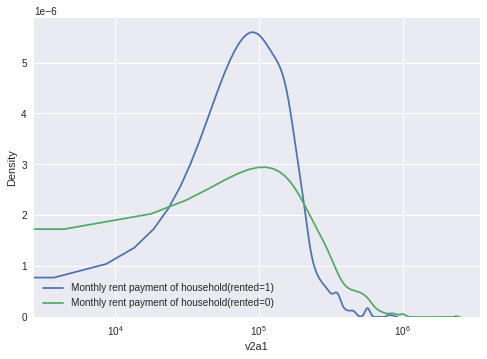

In [22]:
# 집이 임대인 사람중 태블릿의 소유여부 밀도함수
sns.kdeplot(df_train.loc[df_train['tipovivi3'] == 1, 'v2a1'], label='Monthly rent payment of household(rented=1)')
sns.kdeplot(df_train.loc[df_train['tipovivi3'] == 0, 'v2a1'], label='Monthly rent payment of household(rented=0)')
plt.xscale('log')
plt.legend()
plt.show()

In [23]:
df_train['v2a1'].fillna(0, inplace=True)
df_test['v2a1'].fillna(0, inplace=True)

In [24]:
# edjef만 제외하고 나머지 특성의 null값은 정리함.(근데 이게 무슨말이지???null값의 모든 행의 갯수

total = df_train.isnull().sum().sort_values(ascending=False)
percent = 100 * (df_train.isnull().sum() / df_train.isnull().count()).sort_values(ascending=False)
missing_df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_df.head(20)

,Total,Percent
edjef,9557,100.0
v2a1,0,0.0
parentesco10,0,0.0
parentesco11,0,0.0
parentesco12,0,0.0
idhogar,0,0.0
hogar_nin,0,0.0
hogar_adul,0,0.0
hogar_mayor,0,0.0
hogar_total,0,0.0


In [25]:
#왜 100%인지??? test값에 null값이 아닌 값도 있는데???

total = df_test.isnull().sum().sort_values(ascending=False)
percent = 100 * (df_test.isnull().sum() / df_test.isnull().count()).sort_values(ascending=False)
missing_df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_df.head(20)

,Total,Percent
edjef,23856,100.0
hogar_mayor,0,0.0
parentesco10,0,0.0
parentesco11,0,0.0
parentesco12,0,0.0
idhogar,0,0.0
hogar_nin,0,0.0
hogar_adul,0,0.0
hogar_total,0,0.0
parentesco8,0,0.0


## 2. Feature engineering

### 2.1 Object features

In [26]:
features_object = [col for col in df_train.columns if df_train[col].dtype == 'object'] #data type가 object인 열을 반ㅎ환

In [27]:
features_object

['Id', 'idhogar', 'dependency', 'edjefe', 'edjefa']

- dependecy

데이터가 obeject데이터와 integer데이터가 공존하는 Series

In [28]:
# 첫번쨰 방법, some dependencies are Na, fill those with the square root of the square
df_train['dependency'] = np.sqrt(df_train['SQBdependency'])
df_test['dependency'] = np.sqrt(df_test['SQBdependency'])

In [29]:
# df_train['dependency'] = df_train['dependency'].replace({np.inf: 0})
 # inf는 무한대를 나타낸다.
 # dependence에 만약 무한대 값이 있으면 이값을 0으로 바꾼다는 의미  
# df_test['dependency'] = df_test['dependency'].replace({np.inf: 0})

# 두번쨰 방법, 위에 제곱근을 취하는 방식과는 다른 방식으로 yes값이면 10 no이면 0을 대입 함
# def replace_dependency(x):
#     if x == 'yes':
#         return 10
#     elif x == 'no':
#         return 0
#     else:
#         return x

# df_train['dependency'] = df_train['dependency'].apply(replace_dependency).astype(float) #apply는 데이터 프레임에서 똑같은 형식의 데이터에서 내용만 변경된것을 입력할떄 사용하는 메서드
# df_test['dependency'] = df_test['dependency'].apply(replace_dependency).astype(float)


### edjefe
edjefe, years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0
replace yes -> 1 and no -> 0

- edjefe 는 글자와 숫자가 혼합하는 Series
- edjefe는 위의 dpendency처럼 제급값을 갖고 있는 데이터 시리즈가 없다 따라서 위의 두번쨰 방법처럼 1,0 으로 변경해서 object와 integer값이 혼합되어있는 데이터를 유리수만 있는 데이터로 변경한다.

In [30]:
def replace_edjefe(x):
    if x == 'yes':
        return 1
    elif x == 'no':
        return 0
    else:
        return x

df_train['edjefe'] = df_train['edjefe'].apply(replace_edjefe).astype(float)
df_test['edjefe'] = df_test['edjefe'].apply(replace_edjefe).astype(float)

### edjefa
edjefa, years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0
replace yes -> 1 and no -> 0

In [31]:
def replace_edjefa(x):
    if x == 'yes': #yes면 1년이라고 가정.
        return 1
    elif x == 'no':
        return 0
    else:
        return x

df_train['edjefa'] = df_train['edjefa'].apply(replace_edjefa).astype(float)
df_test['edjefa'] = df_test['edjefa'].apply(replace_edjefa).astype(float) #수의 특성으 바꾸는 메서드 (astype)
                                                                          #apply메서드는 기존 dataframe을 신규데이터로 변경할때 사용(똑같은데이터 인데 형식만 변경)

In [32]:
# 남자, 여자 중 더 높은 학력을 가진 사람만 추려서 특성을 만들어 낸다.
# 큰꺽쇠 2개 있으면 추출, 1개있으면 Series값으로만 

df_train['edjef'] = np.max(df_train[['edjefa','edjefe']], axis=1)
df_test['edjef'] = np.max(df_test[['edjefa','edjefe']], axis=1)

### roof and electricity

In [33]:
df_train['roof_waste_material'] = np.nan #nan : Not a number
# Setting a column to all NaN values can be useful in cases where the data is missing or needs to be removed for analysis or modeling.
# 신규의 데이터 Series를 만든다 column 명이 roof_waste_material
df_test['roof_waste_material'] = np.nan
df_train['electricity_other'] = np.nan
df_test['electricity_other'] = np.nan

def fill_roof_exception(x):
    if (x['techozinc'] == 0) and (x['techoentrepiso'] == 0) and (x['techocane'] == 0) and (x['techootro'] == 0):
        return 1
    else:
        return 0
    #지붕의 주요 재료가 금속 포일 또는 징크가 아니고, 
    #지붕의 주요 재료가 섬유 시멘트, 메자닌인이 아니고
    #지붕의 주요 재료가 천연 섬유가 아니고
    #지붕의 주요 재료가 다르지 않은경우, 이 4가지 모두아닌 경우 return 값이 1이다. 
    # 즉,  fill_roof_exception 에서 0을 가지면 집의 소재에 대한 DATA가 있다는 의미이고 1이면 소재에 대한 데이터가 없다는 뜻이다.
    
def fill_no_electricity(x):
    if (x['public'] == 0) and (x['planpri'] == 0) and (x['noelec'] == 0) and (x['coopele'] == 0):
        return 1
    else:
        return 0

df_train['roof_waste_material'] = df_train.apply(lambda x : fill_roof_exception(x),axis=1)
df_test['roof_waste_material'] = df_test.apply(lambda x : fill_roof_exception(x),axis=1)
df_train['electricity_other'] = df_train.apply(lambda x : fill_no_electricity(x),axis=1)
df_test['electricity_other'] = df_test.apply(lambda x : fill_no_electricity(x),axis=1)

### 2.2 Extract cat features
According to data scription, there are many binary category features.

In [34]:
binary_cat_features = [col for col in df_train.columns if df_train[col].value_counts().shape[0] == 2] #남, 녀 처럼 obect중 2가지 값만 가지고 있는 열을 이진 카테고리 특성 리스트라 부름


### 2.3 Make new features using continuous feature

In [35]:
continuous_features = [col for col in df_train.columns if col not in binary_cat_features] #이진 특성이 아니면 연속 특성
continuous_features = [col for col in continuous_features if col not in features_object] #위의 feature object아니면 연속특성
continuous_features = [col for col in continuous_features if col not in ['Id', 'Target', 'idhogar']] #고유값들이 아니여야 한다.

In [36]:
print('There are {} continuous features'.format(len(continuous_features)))
for col in continuous_features:
    print('{}: {}'.format(col, description.loc[description['varname'] == col, 'description'].values))

    #.values : numpy 값으로 데이터를 출력한다.(왜그럴까)
    #. values 없으면 
    # v2a1: 0     Monthly rent payment
    # Name: description, dtype: object  출력

There are 37 continuous features
v2a1: [' Monthly rent payment']
rooms: ['  number of all rooms in the house']
v18q1: [' number of tablets household owns']
r4h1: [' Males younger than 12 years of age']
r4h2: [' Males 12 years of age and older']
r4h3: [' Total males in the household']
r4m1: [' Females younger than 12 years of age']
r4m2: [' Females 12 years of age and older']
r4m3: [' Total females in the household']
r4t1: [' persons younger than 12 years of age']
r4t2: [' persons 12 years of age and older']
r4t3: [' Total persons in the household']
tamhog: [' size of the household']
tamviv: [' number of persons living in the household']
escolari: [' years of schooling']
rez_esc: [' Years behind in school']
hhsize: [' household size']
elimbasu5: [' =1 if rubbish disposal mainly by throwing in river,   creek or sea']
hogar_nin: [' Number of children 0 to 19 in household']
hogar_adul: [' Number of adults in household']
hogar_mayor: [' # of individuals 65+ in the household']
hogar_total: [

In [37]:
#edjef는 위에서 신규로 만든 특성이므로 설명이 없다.
df_train['edjef'].value_counts()

6.0     2792
11.0    1150
9.0      723
8.0      474
15.0     473
3.0      459
0.0      435
7.0      413
4.0      400
5.0      398
14.0     328
17.0     278
2.0      278
16.0     247
10.0     207
12.0     185
13.0     155
1.0       65
21.0      48
18.0      22
19.0      18
20.0       9
Name: edjef, dtype: int64

In [38]:
#유사한 데이터 이므로 버림
df_train.drop('tamhog', axis=1, inplace=True) #inplace=True 는 tamhog열을 버린후 신규 DataFrame을 만드는 것이아니라 기존의 DataFrame에서 작업진행
df_test.drop('tamhog', axis=1, inplace=True)

- Family features (가족의 특성 재정의)


hogar_nin, hogar_adul, hogar_mayor, hogar_total, r4h1, r4h2, r4h3, r4m1, r4m2, r4m3, r4t1, r4t2, r4t3, tmbhog, tamvid, rez_esc, escolari

In [39]:
print(df_train['r4h1'].dtype)
print(df_train['hogar_total'].dtype)

int64
int64


In [40]:
df_train['adult'] = df_train['hogar_adul'] - df_train['hogar_mayor'] # adult를 새롭게 정의 ; 집안의 어른수 - 집안의 65세이상의 노인
df_train['dependency_count'] = df_train['hogar_nin'] + df_train['hogar_mayor'] # 미성년자 + 65세 이상 노인
df_train['dependency'] = df_train['dependency_count'] / df_train['adult']
df_train['child_percent'] = df_train['hogar_nin'] / df_train['hogar_total']
df_train['elder_percent'] = df_train['hogar_mayor'] / df_train['hogar_total']
df_train['adult_percent'] = df_train['hogar_adul'] / df_train['hogar_total']
df_train['males_younger_12_years_percent'] = df_train['r4h1'] / df_train['hogar_total']
df_train['males_older_12_years_percent'] = df_train['r4h2'] / df_train['hogar_total']
df_train['males_percent'] = df_train['r4h3'] / df_train['hogar_total']
df_train['females_younger_12_years_percent'] = df_train['r4m1'] / df_train['hogar_total']
df_train['females_older_12_years_percent'] = df_train['r4m2'] / df_train['hogar_total']
df_train['females_percent'] = df_train['r4m3'] / df_train['hogar_total']
df_train['persons_younger_12_years_percent'] = df_train['r4t1'] / df_train['hogar_total']
df_train['persons_older_12_years_percent'] = df_train['r4t2'] / df_train['hogar_total']
df_train['persons_percent'] = df_train['r4t3'] / df_train['hogar_total']

In [41]:
print(df_test['r4h1'].dtype)
print(df_test['hogar_total'].dtype)

int64
int64


In [42]:
df_test['adult'] = df_test['hogar_adul'] - df_test['hogar_mayor'] #test도 train 과 똑같이 진행
df_test['dependency_count'] = df_test['hogar_nin'] + df_test['hogar_mayor']
df_test['dependency'] = df_test['dependency_count'] / df_test['adult']
df_test['child_percent'] = df_test['hogar_nin'] / df_test['hogar_total']
df_test['elder_percent'] = df_test['hogar_mayor'] / df_test['hogar_total']
df_test['adult_percent'] = df_test['hogar_adul'] / df_test['hogar_total']
df_test['males_younger_12_years_percent'] = df_test['r4h1'] / df_test['hogar_total']
df_test['males_older_12_years_percent'] = df_test['r4h2'] / df_test['hogar_total']
df_test['males_percent'] = df_test['r4h3'] / df_test['hogar_total']
df_test['females_younger_12_years_percent'] = df_test['r4m1'] / df_test['hogar_total']
df_test['females_older_12_years_percent'] = df_test['r4m2'] / df_test['hogar_total']
df_test['females_percent'] = df_test['r4m3'] / df_test['hogar_total']
df_test['persons_younger_12_years_percent'] = df_test['r4t1'] / df_test['hogar_total']
df_test['persons_older_12_years_percent'] = df_test['r4t2'] / df_test['hogar_total']
df_test['persons_percent'] = df_test['r4t3'] / df_test['hogar_total']

In [43]:
df_train['males_younger_12_years_in_household_size'] = df_train['r4h1'] / df_train['hhsize']
df_train['males_older_12_years_in_household_size'] = df_train['r4h2'] / df_train['hhsize']
df_train['males_in_household_size'] = df_train['r4h3'] / df_train['hhsize']
df_train['females_younger_12_years_in_household_size'] = df_train['r4m1'] / df_train['hhsize']
df_train['females_older_12_years_in_household_size'] = df_train['r4m2'] / df_train['hhsize']
df_train['females_in_household_size'] = df_train['r4m3'] / df_train['hogar_total']
df_train['persons_younger_12_years_in_household_size'] = df_train['r4t1'] / df_train['hhsize']
df_train['persons_older_12_years_in_household_size'] = df_train['r4t2'] / df_train['hhsize']
df_train['persons_in_household_size'] = df_train['r4t3'] / df_train['hhsize']

In [44]:
df_test['males_younger_12_years_in_household_size'] = df_test['r4h1'] / df_test['hhsize']
df_test['males_older_12_years_in_household_size'] = df_test['r4h2'] / df_test['hhsize']
df_test['males_in_household_size'] = df_test['r4h3'] / df_test['hhsize']
df_test['females_younger_12_years_in_household_size'] = df_test['r4m1'] / df_test['hhsize']
df_test['females_older_12_years_in_household_size'] = df_test['r4m2'] / df_test['hhsize']
df_test['females_in_household_size'] = df_test['r4m3'] / df_test['hogar_total']
df_test['persons_younger_12_years_in_household_size'] = df_test['r4t1'] / df_test['hhsize']
df_test['persons_older_12_years_in_household_size'] = df_test['r4t2'] / df_test['hhsize']
df_test['persons_in_household_size'] = df_test['r4t3'] / df_test['hhsize']

In [45]:
df_train['overcrowding_room_and_bedroom'] = (df_train['hacdor'] + df_train['hacapo'])/2
df_test['overcrowding_room_and_bedroom'] = (df_test['hacdor'] + df_test['hacapo'])/2

In [46]:
df_train['escolari_age'] = df_train['escolari']/df_train['age']
df_test['escolari_age'] = df_test['escolari']/df_test['age']

df_train['age_12_19'] = df_train['hogar_nin'] - df_train['r4t1']
df_test['age_12_19'] = df_test['hogar_nin'] - df_test['r4t1']  

In [47]:
df_train['phones-per-capita'] = df_train['qmobilephone'] / df_train['tamviv']
df_train['tablets-per-capita'] = df_train['v18q1'] / df_train['tamviv']
df_train['rooms-per-capita'] = df_train['rooms'] / df_train['tamviv']
df_train['rent-per-capita'] = df_train['v2a1'] / df_train['tamviv']

In [48]:
df_test['phones-per-capita'] = df_test['qmobilephone'] / df_test['tamviv']
df_test['tablets-per-capita'] = df_test['v18q1'] / df_test['tamviv']
df_test['rooms-per-capita'] = df_test['rooms'] / df_test['tamviv']
df_test['rent-per-capita'] = df_test['v2a1'] / df_test['tamviv']

In [49]:
(df_train['hogar_total'] == df_train['r4t3']).sum()
# 9559개의 train data set 중 9509개의 데이터만 가구원의 총계와 집에 거주하는 인원 총계 값이 같다.

9509

Rent per family features (특성 15개 추가)

- I will reduce the number of features using shap, so let's generate many features!! Hope catch some fortune features :)

In [50]:
family_size_features = ['adult', 'hogar_adul', 'hogar_mayor', 'hogar_nin', 'hogar_total', 'r4h1', 
                        'r4h2', 'r4h3', 'r4m1', 'r4m2', 'r4m3', 'r4t1', 'r4t2', 'r4t3', 'hhsize']
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('v2a1', col) #v2a1: Monthly rent payment
    new_feats.append(new_col_name) #new_feats 라는 리스트에 새로운 열의 이름을 추가

    df_train[new_col_name] = df_train['v2a1'] / df_train[col] #df_train에서 신규 열 추가 
    df_test[new_col_name] = df_test['v2a1'] / df_test[col]

In [51]:
for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    #By replacing inf with NaN, this code effectively removes any infinite values from the specified column of df_train.
    # inplace=True는 신규 DF를 만드는 것이 아니라 기존의 DF에 무한대 대신 0값으로 대체 한다는 의미
    df_train[col].fillna(0, inplace=True)
    # fillna() method fills any missing(공란) or NaN(숫자가 아닌경우) values with a specified scalar value.
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

Room per family features (특성 15개 추가)

In [52]:
family_size_features = ['adult', 'hogar_adul', 'hogar_mayor', 'hogar_nin', 'hogar_total', 'r4h1', 
                        'r4h2', 'r4h3', 'r4m1', 'r4m2', 'r4m3', 'r4t1', 'r4t2', 'r4t3', 'hhsize']
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('rooms', col)
    new_feats.append(new_col_name) #append는 리스트에 새로운 리스트 추가
    df_train[new_col_name] = df_train['rooms'] / df_train[col]
    df_test[new_col_name] = df_test['rooms'] / df_test[col]

for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True) #무한대 값은 NaN으로 바꾸고 
    df_train[col].fillna(0, inplace=True)                 # 숫자가 아닌 값(object, 빈칸)들은 0으로 바꾼다.
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

BedRoom per family features (특성 15개 추가)


In [53]:
family_size_features = ['adult', 'hogar_adul', 'hogar_mayor', 'hogar_nin', 'hogar_total', 'r4h1', 
                        'r4h2', 'r4h3', 'r4m1', 'r4m2', 'r4m3', 'r4t1', 'r4t2', 'r4t3', 'hhsize']
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('rooms', col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['rooms'] / df_train[col]
    df_test[new_col_name] = df_test['rooms'] / df_test[col]

for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    df_train[col].fillna(0, inplace=True)
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

In [54]:
print(df_train.shape, df_test.shape)

# df_train shape: (9557, 143) df_test shape:  (23856, 142)/ 기존 data보다 특성이 62개 늘었다.

(9557, 205) (23856, 204)


Tablet per family features

In [55]:
new_feats = []
family_size_features = ['adult', 'hogar_adul', 'hogar_mayor', 'hogar_nin', 'hogar_total', 'r4h1', 
                        'r4h2', 'r4h3', 'r4m1', 'r4m2', 'r4m3', 'r4t1', 'r4t2', 'r4t3', 'hhsize']
                        
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('v18q1', col) # v18q1: number of tablets household owns
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['v18q1'] / df_train[col]
    df_test[new_col_name] = df_test['v18q1'] / df_test[col]

for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    df_train[col].fillna(0, inplace=True)
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

phone per family features

In [56]:
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('qmobilephone', col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['qmobilephone'] / df_train[col]
    df_test[new_col_name] = df_test['qmobilephone'] / df_test[col]

for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    df_train[col].fillna(0, inplace=True)
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

rez_esc(Years behind in school) per family features

In [57]:
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('rez_esc', col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['rez_esc'] / df_train[col]
    df_test[new_col_name] = df_test['rez_esc'] / df_test[col]

for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    df_train[col].fillna(0, inplace=True)
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

In [58]:
df_train['rez_esc_age'] = df_train['rez_esc'] / df_train['age']
df_train['rez_esc_escolari'] = df_train['rez_esc'] / df_train['escolari'] # 'escolari' : 평균 학습년도 
                                                                          #              The global average is 8.7 years.     
df_test['rez_esc_age'] = df_test['rez_esc'] / df_test['age']
df_test['rez_esc_escolari'] = df_test['rez_esc'] / df_test['escolari']

Rich features

-I think the more richer, the larger number of phones and tablet (가정)

In [59]:
df_train['tabulet_x_qmobilephone'] = df_train['v18q1'] * df_train['qmobilephone']
df_test['tabulet_x_qmobilephone'] = df_test['v18q1'] * df_test['qmobilephone']

wall, roof, floor may be key factor.
Let's multiply each of them. Becuase they are binary cat features, so mulitification of each features generates new categorical features

In [60]:
# wall and roof
for col1 in ['epared1', 'epared2', 'epared3']:
    for col2 in ['etecho1', 'etecho2', 'etecho3']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2] #이름 만 만들어주고  columns 명만 만들어 준다. 
        df_test[new_col_name] = df_test[col1] * df_test[col2]
        
# wall and floor
for col1 in ['epared1', 'epared2', 'epared3']:
    for col2 in ['eviv1', 'eviv2', 'eviv3']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

# roof and floor
for col1 in ['etecho1', 'etecho2', 'etecho3']:
    for col2 in ['eviv1', 'eviv2', 'eviv3']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

combination using three features

In [61]:
for col1 in ['epared1', 'epared2', 'epared3']:
    for col2 in ['etecho1', 'etecho2', 'etecho3']:
        for col3 in ['eviv1', 'eviv2', 'eviv3']:
            new_col_name = 'new_{}_x_{}_x_{}'.format(col1, col2, col3)
            df_train[new_col_name] = df_train[col1] * df_train[col2] * df_train[col3]
            df_test[new_col_name] = df_test[col1] * df_test[col2] * df_train[col3]

In [62]:
print(df_train.shape, df_test.shape)

(9557, 307) (23856, 306)


I want to mix electricity and energy features -> energy features

In [63]:
for col1 in ['public', 'planpri', 'noelec', 'coopele']:
    for col2 in ['energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

I want to mix toilet and rubbish disposal features -> other_infra features

In [64]:
for col1 in ['sanitario1', 'sanitario2', 'sanitario3', 'sanitario5', 'sanitario6']:
    for col2 in ['elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 'elimbasu5', 'elimbasu6']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2] #daraframe 안에 list로 들어가면 데이터 프레임안의 열을 추출해낸다.
        df_test[new_col_name] = df_test[col1] * df_test[col2]
#("sanitario1","=1주거지에 화장실 없음"),
#("sanitario2","=하수도 또는 하수구에 연결된 화장실 1개"),
#("sanitario3","= 정화조에 연결된 화장실 1개"),
#("sanitario5","=블랙홀 또는 레트린에 연결된 화장실 1개"),
#("sanitario6","=다른 시스템에 연결된 화장실 1개"),

#("elimbasu1","=1 유조선 트럭에 의한 쓰레기 처리의 경우"),
#("elimbasu2","=1 주로 식물성 중공 또는 매립에 의한 쓰레기 처리"),
#("elimbasu3","=1 주로 불에 태워 폐기물을 처리하는 경우"),
#("elimbasu4","=1 빈 공간에 주로 던져서 쓰레기를 처리하는 경우"),
#("elimbasu5","=1 주로 강, 하천 또는 바다에 투척하여 쓰레기를 처리하는 경우"),
#("elimbasu6","=1 쓰레기 처리가 주로 다른 경우")


I want to mix toilet and water provision features -> water features

In [65]:
for col1 in ['area1', 'area2']:
    for col2 in ['instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

#("instlevel1","=1 교육 수준 없음"),
#("instlevel2","=1 불완전한 초등교육"),
#("instlevel3","=1 완전한 초등교육"),
#("instlevel4","=1 불완전한 학업 2차 수준"),
#("instlevel5","=1 완전한 학문적 2차 수준"),
#("instlevel6","=1 불완전한 기술 2차 수준"),
#("instlevel7","=1 완전한 기술 2차 수준"),
#("instlevel8","=1학부 이상"),
#("instlevel9","=1 대학원 고등교육"),

#("area1"," =1 zona urbana"),= urban zone
#("area2"," =2 zona rural"),= rural zone(시골)

In [66]:
print(df_train.shape, df_test.shape)

(9557, 371) (23856, 370)


In [67]:
for col1 in ['abastaguadentro', 'abastaguafuera', 'abastaguano']:
    for col2 in ['sanitario1', 'sanitario2', 'sanitario3', 'sanitario5', 'sanitario6']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

Mix region and education

In [68]:
for col1 in ['area1', 'area2']:
    for col2 in ['instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

In [69]:
for col1 in ['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6']:
    for col2 in ['instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

In [70]:
print(df_train.shape, df_test.shape)

(9557, 440) (23856, 439)


Multiply television / mobilephone / computer / tabulet / refrigerator -> electornics featu

In [71]:
df_train['electronics'] = df_train['computer'] * df_train['mobilephone'] * df_train['television'] * df_train['v18q'] * df_train['refrig']
df_test['electronics'] = df_test['computer'] * df_test['mobilephone'] * df_test['television'] * df_test['v18q'] * df_test['refrig']

df_train['no_appliances'] = df_train['refrig'] + df_train['computer'] + df_train['television'] + df_train['mobilephone']
df_test['no_appliances'] = df_test['refrig'] + df_test['computer'] + df_test['television'] + df_test['mobilephone']


Mix wall material of roof, floor, wall

In [72]:
for col1 in ['paredblolad', 'paredzocalo', 'paredpreb', 'pareddes', 'paredmad', 'paredzinc', 'paredfibras', 'paredother']:
    for col2 in ['pisomoscer', 'pisocemento', 'pisoother', 'pisonatur', 'pisonotiene', 'pisomadera']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

for col1 in ['pisomoscer', 'pisocemento', 'pisoother', 'pisonatur', 'pisonotiene', 'pisomadera']:
    for col1 in ['techozinc', 'techoentrepiso', 'techocane', 'techootro']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]
        
for col1 in ['paredblolad', 'paredzocalo', 'paredpreb', 'pareddes', 'paredmad', 'paredzinc', 'paredfibras', 'paredother']:
    for col2 in ['techozinc', 'techoentrepiso', 'techocane', 'techootro']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]        
        
for col1 in ['paredblolad', 'paredzocalo', 'paredpreb', 'pareddes', 'paredmad', 'paredzinc', 'paredfibras', 'paredother']:
    for col2 in ['pisomoscer', 'pisocemento', 'pisoother', 'pisonatur', 'pisonotiene', 'pisomadera']:
        for col3 in ['techozinc', 'techoentrepiso', 'techocane', 'techootro']:
            new_col_name = 'new_{}_x_{}_x_{}'.format(col1, col2, col3)
            df_train[new_col_name] = df_train[col1] * df_train[col2] * df_train[col3]
            df_test[new_col_name] = df_test[col1] * df_test[col2] * df_train[col3]

In [73]:
print(df_train.shape, df_test.shape)

(9557, 718) (23856, 717)


Remove feature with only one value

In [74]:
cols_with_only_one_value = []
for col in df_train.columns: #이렇게 df_train의 columns의 리스트를 뽑을 수 있다.
    if col == 'Target':
        continue
    if df_train[col].value_counts().shape[0] == 1 or df_test[col].value_counts().shape[0] == 1:
        print(col)
        cols_with_only_one_value.append(col)
        #shape 형태가 1이면 하나의 값만 가지므로 제거한다.

elimbasu5
new_planpri_x_energcocinar1
new_planpri_x_energcocinar2
new_planpri_x_energcocinar3
new_planpri_x_energcocinar4
new_noelec_x_energcocinar2
new_sanitario1_x_elimbasu4
new_sanitario1_x_elimbasu5
new_sanitario1_x_elimbasu6
new_sanitario2_x_elimbasu4
new_sanitario2_x_elimbasu5
new_sanitario2_x_elimbasu6
new_sanitario3_x_elimbasu5
new_sanitario5_x_elimbasu4
new_sanitario5_x_elimbasu5
new_sanitario5_x_elimbasu6
new_sanitario6_x_elimbasu2
new_sanitario6_x_elimbasu4
new_sanitario6_x_elimbasu5
new_sanitario6_x_elimbasu6
new_abastaguafuera_x_sanitario6
new_abastaguano_x_sanitario2
new_abastaguano_x_sanitario6
new_paredblolad_x_pisonatur
new_paredblolad_x_pisonotiene
new_paredzocalo_x_pisoother
new_paredzocalo_x_pisonatur
new_paredpreb_x_pisonatur
new_pareddes_x_pisoother
new_pareddes_x_pisonatur
new_paredmad_x_pisoother
new_paredmad_x_pisonatur
new_paredzinc_x_pisoother
new_paredzinc_x_pisonatur
new_paredfibras_x_pisoother
new_paredfibras_x_pisonatur
new_paredfibras_x_pisonotiene
new_p

Let's remove them!

In [75]:
df_train.drop(cols_with_only_one_value, axis=1, inplace=True)
df_test.drop(cols_with_only_one_value, axis=1, inplace=True)

Check whether both train and test have same features

In [76]:
cols_train = np.array(sorted([col for col in df_train.columns if col != 'Target']))
cols_test = np.array(sorted(df_test.columns))

In [77]:
(cols_train == cols_test).sum() == len(cols_train)

True

### 2.4 aggregation features

In this competition, each samples are member of spectific household(idhogar). So let's aggregate based on 'idhogar' values.


In [78]:
# idhogar : Household level identifier
# 식별자 별로 분류를 한다.

Aggregation for family features

In [79]:
def max_min(x):
    return x.max() - x.min()

In [99]:
agg_train = pd.DataFrame()
agg_test = pd.DataFrame()
family_size_features = ['adult', 'hogar_adul', 'hogar_mayor', 'hogar_nin', 'hogar_total', 'r4h1', 
                        'r4h2', 'r4h3', 'r4m1', 'r4m2', 'r4m3', 'r4t1', 'r4t2', 'r4t3', 'hhsize']
                        
for item in tqdm(family_size_features):#family size features에 대한 잔행률을 표사해준다.
    for i, function in enumerate(['mean','std','min','max','sum', 'count', max_min]):
        group_train = df_train[item].groupby(df_train['idhogar']).agg(function)
        group_test = df_test[item].groupby(df_test['idhogar']).agg(function)
        if i == 6:
            new_col = item + '_new_' + 'max_min'
        else:
            new_col = item + '_new_' + function
        agg_train[new_col] = group_train
        agg_test[new_col] = group_test
       #groupby() method is used to group rows in each dataset by a common identifier, 
       #idhogar, which represents the household to which each individual belongs.
      # enumerate, 함수는 index와 element값을 동시에 출력하는 함수 [(0,'adult'),(1, 'hogar_adul') ]이런식으로 표현
      # agg() method is then used to apply the specified function to each group, resulting in a new DataFrame with one row per household.
print('new aggregate train set has {} rows, and {} features'.format(agg_train.shape[0], agg_train.shape[1]))
print('new aggregate test set has {} rows, and {} features'.format(agg_test.shape[0], agg_test.shape[1]))


100%|██████████| 15/15 [00:21<00:00,  1.41s/it]

new aggregate train set has 2988 rows, and 105 features
new aggregate test set has 7352 rows, and 105 features


aggregation에 대한 예제

In [97]:
animals = pd.DataFrame(
    {
        "kind": ["cat", "dog", "cat", "dog"],
        "height": [9.1, 6.0, 9.5, 34.0],
        "weight": [7.9, 7.5, 9.9, 198.0],
    }
)
print(animals)

  kind  height  weight
0  cat     9.1     7.9
1  dog     6.0     7.5
2  cat     9.5     9.9
3  dog    34.0   198.0


In [96]:
animals.groupby("kind").agg(
    min_height=pd.NamedAgg(column="height", aggfunc="min"),
    max_height=pd.NamedAgg(column="height", aggfunc="max"),
    average_weight=pd.NamedAgg(column="weight", aggfunc=np.mean),
)


,min_height,max_height,average_weight
kind,,,
cat,9.1,9.5,8.90
dog,6.0,34.0,102.75


In [98]:
ggr_list = ['rez_esc', 'dis', 'male', 'female', 
                  'estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
                  'parentesco2', 'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7', 'parentesco8', 'parentesco9', 'parentesco10', 
                  'parentesco11', 'parentesco12',
                  'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9',
                 'epared1', 'epared2', 'epared3', 'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 'refrig', 'television', 'mobilephone',
            'area1', 'area2', 'v18q', 'edjef']


for item in tqdm(ggr_list):
    for function in ['count', 'sum']:
        group_train = df_train[item].groupby(df_train['idhogar']).agg(function)
        group_test = df_test[item].groupby(df_test['idhogar']).agg(function)
        new_col = item + '_new1_' + function
        agg_train[new_col] = group_train
        agg_test[new_col] = group_test
print('new aggregate train set has {} rows, and {} features'.format(agg_train.shape[0], agg_train.shape[1]))
print('new aggregate test set has {} rows, and {} features'.format(agg_test.shape[0], agg_test.shape[1]))

100%|██████████| 47/47 [00:00<00:00, 53.97it/s]

new aggregate train set has 2988 rows, and 199 features
new aggregate test set has 7352 rows, and 199 features


In [82]:
aggr_list = ['escolari', 'age', 'escolari_age', 'dependency', 'bedrooms', 'overcrowding', 'rooms', 'qmobilephone', 'v18q1']

for item in tqdm(aggr_list):
    for function in ['mean','std','min','max','sum', 'count', max_min]:
        group_train = df_train[item].groupby(df_train['idhogar']).agg(function)
        group_test = df_test[item].groupby(df_test['idhogar']).agg(function)
        if i == 6:
            new_col = item + '_new2_' + 'max_min'
        else:
            new_col = item + '_new2_' + function
        agg_train[new_col] = group_train
        agg_test[new_col] = group_test

print('new aggregate train set has {} rows, and {} features'.format(agg_train.shape[0], agg_train.shape[1]))
print('new aggregate test set has {} rows, and {} features'.format(agg_test.shape[0], agg_test.shape[1]))

100%|██████████| 9/9 [00:16<00:00,  1.84s/it]

new aggregate train set has 2988 rows, and 208 features
new aggregate test set has 7352 rows, and 208 features


In [83]:
gg_test = agg_test.reset_index()
agg_train = agg_train.reset_index()

train_agg = pd.merge(df_train, agg_train, on='idhogar')
test = pd.merge(df_test, agg_test, on='idhogar')

#fill all na as 0
train_agg.fillna(value=0, inplace=True)
test.fillna(value=0, inplace=True)

print('train shape:', train_agg.shape, 'test shape:', test.shape)

train shape: (9557, 709) test shape: (23856, 708)


In [84]:
aggr_list = ['rez_esc', 'dis', 'male', 'female', 
                  'estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
                  'parentesco2', 'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7', 'parentesco8', 'parentesco9', 'parentesco10', 
                  'parentesco11', 'parentesco12',
                  'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9',
                 'epared1', 'epared2', 'epared3', 'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 'refrig', 'television', 'mobilephone',
            'area1', 'area2', 'v18q', 'edjef']
    
for lugar in ['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6']:
    group_train = df_train[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).sum().reset_index()
    group_train.columns = [lugar, 'idhogar'] + ['new3_{}_idhogar_{}'.format(lugar, col) for col in group_train][2:]

    group_test = df_test[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).sum().reset_index()
    group_test.columns = [lugar, 'idhogar'] + ['new3_{}_idhogar_{}'.format(lugar, col) for col in group_test][2:]

    train_agg = pd.merge(train_agg, group_train, on=[lugar, 'idhogar'])
    test = pd.merge(test, group_test, on=[lugar, 'idhogar'])
    
print('train shape:', train_agg.shape, 'test shape:', test.shape)

train shape: (9557, 991) test shape: (23856, 990)


In [85]:
aggr_list = ['rez_esc', 'dis', 'male', 'female', 
                  'estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
                  'parentesco2', 'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7', 'parentesco8', 'parentesco9', 'parentesco10', 
                  'parentesco11', 'parentesco12',
                  'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9',
                 'epared1', 'epared2', 'epared3', 'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 'refrig', 'television', 'mobilephone',
            'area1', 'area2', 'v18q', 'edjef']
    
for lugar in ['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6']:
    group_train = df_train[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).sum().reset_index()
    group_train.columns = [lugar, 'idhogar'] + ['new4_{}_idhogar_{}'.format(lugar, col) for col in group_train][2:]

    group_test = df_test[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).sum().reset_index()
    group_test.columns = [lugar, 'idhogar'] + ['new4_{}_idhogar_{}'.format(lugar, col) for col in group_test][2:]

    train_agg = pd.merge(train_agg, group_train, on=[lugar, 'idhogar'])
    test = pd.merge(test, group_test, on=[lugar, 'idhogar'])
    
print('train shape:', train_agg.shape, 'test shape:', test.shape)

train shape: (9557, 1273) test shape: (23856, 1272)


In [86]:
cols_nums = ['age', 'meaneduc', 'dependency', 
             'hogar_nin', 'hogar_adul', 'hogar_mayor', 'hogar_total',
             'bedrooms', 'overcrowding']

for function in tqdm(['mean','std','min','max','sum', 'count', max_min]):
    for lugar in ['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6']:
        group_train = df_train[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).agg(function).reset_index()
        group_train.columns = [lugar, 'idhogar'] + ['new5_{}_idhogar_{}_{}'.format(lugar, col, function) for col in group_train][2:]

        group_test = df_test[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).agg(function).reset_index()
        group_test.columns = [lugar, 'idhogar'] + ['new5_{}_idhogar_{}_{}'.format(lugar, col, function) for col in group_test][2:]

        train_agg = pd.merge(train_agg, group_train, on=[lugar, 'idhogar'])
        test = pd.merge(test, group_test, on=[lugar, 'idhogar'])
        
print('train shape:', train_agg.shape, 'test shape:', test.shape)

100%|██████████| 7/7 [05:47<00:00, 49.71s/it] 

train shape: (9557, 3247) test shape: (23856, 3246)


- According to data descriptions,ONLY the heads of household are used in scoring. /
All household members are included in test + the sample submission, but only heads of households are scored.

In [87]:
train = train_agg.query('parentesco1==1')

In [88]:
train['dependency'].replace(np.inf, 0, inplace=True)
test['dependency'].replace(np.inf, 0, inplace=True)

In [89]:
submission = test[['Id']]

#Remove useless feature to reduce dimension
train.drop(columns=['idhogar','Id', 'agesq', 'hogar_adul', 'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned'], inplace=True)
test.drop(columns=['idhogar','Id',  'agesq', 'hogar_adul', 'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned'], inplace=True)

correlation = train.corr()
correlation = correlation['Target'].sort_values(ascending=False)

In [90]:
print('final_data size', train.shape, test.shape)

final_data size (2973, 3235) (23856, 3234)


In [91]:
print(f'The most 20 positive feature: \n{correlation.head(40)}')

The most 20 positive feature: 
Target                                1.000000
new5_lugar2_idhogar_edjef_max         0.334254
new5_lugar6_idhogar_edjef_max         0.334254
new5_lugar4_idhogar_edjef_max         0.334254
new5_lugar1_idhogar_edjef_max         0.334254
new5_lugar5_idhogar_edjef_max         0.334254
new5_lugar3_idhogar_edjef_max         0.334254
new5_lugar2_idhogar_edjef_mean        0.333873
new5_lugar5_idhogar_edjef_mean        0.333873
new5_lugar6_idhogar_edjef_mean        0.333873
new5_lugar1_idhogar_edjef_mean        0.333873
new5_lugar3_idhogar_edjef_mean        0.333873
new5_lugar4_idhogar_edjef_mean        0.333873
edjef                                 0.333791
new5_lugar4_idhogar_edjef_min         0.333791
new5_lugar3_idhogar_edjef_min         0.333791
new5_lugar1_idhogar_edjef_min         0.333791
new5_lugar6_idhogar_edjef_min         0.333791
new5_lugar5_idhogar_edjef_min         0.333791
new5_lugar2_idhogar_edjef_min         0.333791
escolari                     

In [92]:
print(f'The most 20 negative feature: \n{correlation.tail(20)}')

The most 20 negative feature: 
new5_lugar5_idhogar_television_<function max_min at 0x7effa9b91ee0>    NaN
new5_lugar5_idhogar_mobilephone_<function max_min at 0x7effa9b91ee0>   NaN
new5_lugar5_idhogar_area1_<function max_min at 0x7effa9b91ee0>         NaN
new5_lugar5_idhogar_area2_<function max_min at 0x7effa9b91ee0>         NaN
new5_lugar5_idhogar_v18q_<function max_min at 0x7effa9b91ee0>          NaN
new5_lugar6_idhogar_epared1_<function max_min at 0x7effa9b91ee0>       NaN
new5_lugar6_idhogar_epared2_<function max_min at 0x7effa9b91ee0>       NaN
new5_lugar6_idhogar_epared3_<function max_min at 0x7effa9b91ee0>       NaN
new5_lugar6_idhogar_etecho1_<function max_min at 0x7effa9b91ee0>       NaN
new5_lugar6_idhogar_etecho2_<function max_min at 0x7effa9b91ee0>       NaN
new5_lugar6_idhogar_etecho3_<function max_min at 0x7effa9b91ee0>       NaN
new5_lugar6_idhogar_eviv1_<function max_min at 0x7effa9b91ee0>         NaN
new5_lugar6_idhogar_eviv2_<function max_min at 0x7effa9b91ee0>       

## 3. Feature selection using shap